## Fine-Tuning a Language Model

In [ ]:
%pip install transformers tokenizers datasets

from tqdm.notebook import tqdm
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

clear_output()

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling, TrainingArguments, Trainer

In [ ]:
!git clone https://github.com/cardiffnlp/tweeteval.git

Cloning into 'tweeteval'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 367 (delta 21), reused 13 (delta 4), pack-reused 318
Receiving objects: 100% (367/367), 10.79 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
dataset = load_dataset('text', data_files={'train': ['/content/tweeteval/datasets/hate/train_text.txt', 
                                                     '/content/tweeteval/datasets/hate/test_text.txt', 
                                                     '/content/tweeteval/datasets/hate/val_text.txt']})

clear_output()
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 12970
    })
})

In [ ]:
model_name = "roberta-base" #@param {type:"string"}
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

clear_output()

In [ ]:
MAX_LENGTH = 512 #@param {type:"integer"}

def tokenize_and_encode(example):
  return tokenizer(example["text"], truncation=True, padding=True, max_length=MAX_LENGTH)

tokenized_dataset = dataset.map(tokenize_and_encode, batched=True, load_from_cache_file=False, batch_size=64)


  0%|          | 0/203 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

training_args = TrainingArguments(
    output_dir="./roberta-retrained",
    overwrite_output_dir=True,
    num_train_epochs=25,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    seed=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset['train']
)


In [ ]:
trainer.train()

### Test the Model

In [ ]:
from transformers import pipeline

In [ ]:
unmasker1 = pipeline('fill-mask', model=model_name)
unmasker2 = pipeline('fill-mask', model='/content/roberta-retrained/checkpoint-12500', tokenizer=model_name)

clear_output()

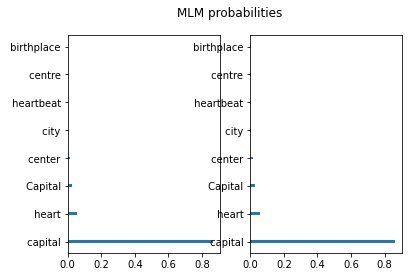

In [ ]:
input_sentence = "Paris is the <mask> of France." #@param {type:"string"}
top_k =  8#@param {type:"integer"}

def plot_probs(ax, unmasker, input_sentence, top_k):
  result = unmasker(input_sentence, top_k=top_k)

  words = list(map(lambda item: item['token_str'], result))
  probabilities = list(map(lambda item: item['score'], result))

  ax.barh(words, probabilities, height=0.1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('MLM probabilities')
plot_probs(ax1, unmasker1, input_sentence, top_k)
plot_probs(ax2, unmasker2, input_sentence, top_k)


## Custom Behaviours in Trainer API

In [ ]:
import random
import warnings
from dataclasses import dataclass
from transformers import DataCollatorForLanguageModeling
from transformers.tokenization_utils_base import BatchEncoding, PreTrainedTokenizerBase
from transformers.models.bert import BertTokenizer, BertTokenizerFast
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def _torch_collate_batch(examples, tokenizer, pad_to_multiple_of: Optional[int] = None):
    """Collate `examples` into a batch, using the information in `tokenizer` for padding if necessary."""
    import numpy as np
    import torch

    # Tensorize if necessary.
    if isinstance(examples[0], (list, tuple, np.ndarray)):
        examples = [torch.tensor(e, dtype=torch.long) for e in examples]

    length_of_first = examples[0].size(0)

    # Check if padding is necessary.

    are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
    if are_tensors_same_length and (pad_to_multiple_of is None or length_of_first % pad_to_multiple_of == 0):
        return torch.stack(examples, dim=0)

    # If yes, check if we have a `pad_token`.
    if tokenizer._pad_token is None:
        raise ValueError(
            "You are attempting to pad samples but the tokenizer you are using"
            f" ({tokenizer.__class__.__name__}) does not have a pad token."
        )

    # Creating the full tensor and filling it with our data.
    max_length = max(x.size(0) for x in examples)
    if pad_to_multiple_of is not None and (max_length % pad_to_multiple_of != 0):
        max_length = ((max_length // pad_to_multiple_of) + 1) * pad_to_multiple_of
    result = examples[0].new_full([len(examples), max_length], tokenizer.pad_token_id)
    for i, example in enumerate(examples):
        if tokenizer.padding_side == "right":
            result[i, : example.shape[0]] = example
        else:
            result[i, -example.shape[0] :] = example
    return result

def tolist(x):
    if isinstance(x, list):
        return x
    elif hasattr(x, "numpy"):  # Checks for TF tensors without needing the import
        x = x.numpy()
    return x.tolist()

In [ ]:
@dataclass
class DataCollatorForLMBasedOnPOSTag(DataCollatorForLanguageModeling):

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        if isinstance(examples[0], (dict, BatchEncoding)):
            input_ids = [e["input_ids"] for e in examples]
        else:
            input_ids = examples
            examples = [{"input_ids": e} for e in examples]

        batch_input = _torch_collate_batch(input_ids, self.tokenizer, pad_to_multiple_of=self.pad_to_multiple_of)

        mask_labels = []
        for e in examples:
            ref_tokens = []
            for id in tolist(e["input_ids"]):
                token = self.tokenizer._convert_id_to_token(id)
                ref_tokens.append(token)
            
            # print(nltk.word_tokenize(tokenizer.decode(e["input_ids"], skip_special_tokens=True)))
            pos_tags = list(map(lambda x: x[1], nltk.pos_tag(nltk.word_tokenize(tokenizer.decode(e["input_ids"], skip_special_tokens=True)))))

            mask_labels.append(self._whole_word_mask(ref_tokens, pos_tags))

        batch_mask = _torch_collate_batch(mask_labels, self.tokenizer, pad_to_multiple_of=self.pad_to_multiple_of)
        inputs, labels = self.torch_mask_tokens(batch_input, batch_mask)
        return {"input_ids": inputs, "labels": labels}

    def _whole_word_mask(self, input_tokens: List[str], pos_tags: List[str], max_predictions=512):
        """
        Get 0/1 labels for masked tokens with whole word mask proxy
        """
        if not isinstance(self.tokenizer, (BertTokenizer, BertTokenizerFast)):
            warnings.warn(
                "DataCollatorForWholeWordMask is only suitable for BertTokenizer-like tokenizers. "
                "Please refer to the documentation for more information."
            )

        # mlm_tag_list = ['JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNS']
        mlm_tag_list = ['JJ', 'JJR', 'JJS']

        cand_indexes = []
        index = -1

        print(pos_tags)
        print(input_tokens)
        
        for (i, token) in enumerate(input_tokens):
            if token == "[CLS]" or token == "[SEP]" or token == "[PAD]":
                continue

            if token.startswith("##"):
                if pos_tags[index] in mlm_tag_list:
                    cand_indexes[-1].append(i)
            else:
                index += 1
                if pos_tags[index] in mlm_tag_list:
                    cand_indexes.append([i])
            
            print(cand_indexes)

        print(cand_indexes)

        raise Exception

        random.shuffle(cand_indexes)
        num_to_predict = min(max_predictions, max(1, int(round(len(input_tokens) * self.mlm_probability))))
        masked_lms = []
        covered_indexes = set()
        for index_set in cand_indexes:
            if len(masked_lms) >= num_to_predict:
                break
            # If adding a whole-word mask would exceed the maximum number of
            # predictions, then just skip this candidate.
            if len(masked_lms) + len(index_set) > num_to_predict:
                continue
            is_any_index_covered = False
            for index in index_set:
                if index in covered_indexes:
                    is_any_index_covered = True
                    break
            if is_any_index_covered:
                continue
            for index in index_set:
                covered_indexes.add(index)
                masked_lms.append(index)

        if len(covered_indexes) != len(masked_lms):
            raise ValueError("Length of covered_indexes is not equal to length of masked_lms.")
        mask_labels = [1 if i in covered_indexes else 0 for i in range(len(input_tokens))]
        return mask_labels

    def torch_mask_tokens(self, inputs: Any, mask_labels: Any) -> Tuple[Any, Any]:
        """
        Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. Set
        'mask_labels' means we use whole word mask (wwm), we directly mask idxs according to it's ref.
        """
        import torch

        if self.tokenizer.mask_token is None:
            raise ValueError(
                "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
            )
        labels = inputs.clone()
        # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)

        probability_matrix = mask_labels

        special_tokens_mask = [
            self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
        ]
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
        if self.tokenizer._pad_token is not None:
            padding_mask = labels.eq(self.tokenizer.pad_token_id)
            probability_matrix.masked_fill_(padding_mask, value=0.0)

        masked_indices = probability_matrix.bool()
        labels[~masked_indices] = -100  # We only compute loss on masked tokens

        # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
        inputs[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # 10% of the time, we replace masked input tokens with random word
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tokenizer), labels.shape, dtype=torch.long)
        inputs[indices_random] = random_words[indices_random]

        # The rest of the time (10% of the time) we keep the masked input tokens unchanged
        return inputs, labels

In [ ]:
model_name = "bert-base-uncased" #@param {type:"string"}
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

clear_output()

In [ ]:
MAX_LENGTH = 512 #@param {type:"integer"}

def tokenize_and_encode(example):
  return tokenizer(example["text"], truncation=True, padding=True, max_length=MAX_LENGTH)

tokenized_dataset = dataset.map(tokenize_and_encode, batched=True, load_from_cache_file=False, batch_size=64)


  0%|          | 0/203 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorForLMBasedOnPOSTag(tokenizer=tokenizer, mlm=True, mlm_probability=0.8)

training_args = TrainingArguments(
    output_dir="./bert-retrained",
    overwrite_output_dir=True,
    num_train_epochs=25,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    seed=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset['train']
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text. If text are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12970
  Num Epochs = 25
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 162125


['VBG', 'JJ', 'NNS', 'VBZ', 'RB', 'DT', 'CD', ':', 'NN', 'NN']
['[CLS]', 'det', '##ain', '##ing', 'immigrant', 'kids', 'is', 'now', 'a', 'billion', '-', 'dollar', 'industry', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[]
[]
[]
[[4]]
[[4]]
[[4]]
[[4]]
[[4]]
[[4]]
[[4]]
[[4]]
[[4]]
[[4]]


Exception: ignored